In [1]:
from Synthetic_Funcs import *

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import torch
#import torch.nn.functional as F
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Turn warnings off for notebook publication
import warnings
warnings.filterwarnings("ignore")


data = 'https://raw.githubusercontent.com/trojrobert/Classification-of-heart-disease-uci-data-/master/heart.csv'
df = pd.read_csv(data)

In [3]:
#one hot encoding
obj_cols = ['cp', 'restecg', 'slope', 'ca']
for col in obj_cols:
    df = pd.get_dummies(df, columns=[col], prefix = [col])
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,thal,target,...,restecg_1,restecg_2,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4
0,63,1,145,233,1,150,0,2.3,1,1,...,0,0,1,0,0,1,0,0,0,0
1,37,1,130,250,0,187,0,3.5,2,1,...,1,0,1,0,0,1,0,0,0,0
2,41,0,130,204,0,172,0,1.4,2,1,...,0,0,0,0,1,1,0,0,0,0
3,56,1,120,236,0,178,0,0.8,2,1,...,1,0,0,0,1,1,0,0,0,0
4,57,0,120,354,0,163,1,0.6,2,1,...,1,0,0,0,1,1,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split
df = df.drop(['thal'], axis=1)
df = df.rename(columns={'target': 'label'})
X = df.drop(['label'], axis=1)
y = df['label']

In [5]:
results = pd.DataFrame()

In [6]:
#raw data
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')
    
    # Split training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=run)
    
    # Standardise data    
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['raw_mean'] = accuracy_array.mean(axis=0)
results['raw_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)
results.index = accuracy_measure_names

results

1 2 3 4 5 

,raw_mean,raw_sem
accuracy,0.831579,0.019122
sensitivity,0.910361,0.017578
specificity,0.728766,0.022361
positive_likelihood,3.505941,0.370214
negative_likelihood,0.378579,0.041756
diagnostic_odds_ratio,10.543215,2.438864
true_positive_rate,0.910361,0.017578
true_negative_rate,0.728766,0.022361
false_positive_rate,0.271234,0.022361
false_negative_rate,0.089639,0.017578


In [7]:
def make_synthetic_data_pc(X_original, y_original, number_of_samples=1000, 
                           n_components=0):
    
    """
    Synthetic data generation.
    Calls on `get_principal_component_model` for PCA model
    If number of components not defined then the function sets it to the number
      of features in X
    
    Inputs
    ------
    original_data: X, y numpy arrays
    number_of_samples: number of synthetic samples to generate
    n_components: number of principal components to use for data synthesis
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
    from sklearn.decomposition import PCA
    # If number of PCA not passed, set to number fo features in X
    if n_components == 0:
        n_components = X_original.shape[1]
    
    # Split the training data into positive and negative
    mask = y_original == 1
    X_train_pos = X_original[mask]
    mask = y_original == 0
    X_train_neg = X_original[mask]
    
    # Pass negative and positive label X data sets to Principal Component Analysis 
    pca_pos = get_principal_component_model(X_train_pos, n_components)
    pca_neg = get_principal_component_model(X_train_neg, n_components)
    
    # Set up list to hold negative and positive label transformed data
    transformed_X = []
    
    # Create synthetic data for positive and neagtive PCA models 
    for pca_model in [pca_pos, pca_neg]:
        
        # Get PCA tranformed data
        transformed = pca_model['transformed_X']
        
        # Get means and standard deviations, to use for sampling
        means = transformed.mean(axis=0)
        stds = transformed.std(axis=0)
    
        # Make synthetic PC data using sampling from normal distributions
        synthetic_pca_data = np.zeros((number_of_samples, n_components))
        for pc in range(n_components):
            synthetic_pca_data[:, pc] =                 np.random.normal(means[pc], stds[pc], size=number_of_samples)
        transformed_X.append(synthetic_pca_data)
        
    # Reverse transform data to create synthetic data to be used
    X_synthetic_pos = pca_pos['model'].inverse_transform(transformed_X[0])
    X_synthetic_neg = pca_neg['model'].inverse_transform(transformed_X[1])
    y_synthetic_pos = np.ones((X_synthetic_pos.shape[0],1))
    y_synthetic_neg = np.zeros((X_synthetic_neg.shape[0],1))
    # Combine positive and negative and shuffle rows
    X_synthetic = np.concatenate((X_synthetic_pos, X_synthetic_neg), axis=0)
    y_synthetic = np.concatenate((y_synthetic_pos, y_synthetic_neg), axis=0)
    
    # Randomise order of X, y
    synthetic = np.concatenate((X_synthetic, y_synthetic), axis=1)
    shuffle_index = np.random.permutation(np.arange(X_synthetic.shape[0]))
    synthetic = synthetic[shuffle_index]
    X_synthetic = synthetic[:,0:-1]
    y_synthetic = synthetic[:,-1]
                                                                   
    return X_synthetic, y_synthetic

In [8]:
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []
synthetic_data = []

for run in range(number_of_runs):
    
    # Split training and test set
    # Split training and test set

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=run)

    # Get synthetic data
    X_synthetic, y_synthetic = make_synthetic_data_pc(
        X_train, y_train, number_of_samples=1000)
    
    # Print progress
    print (run + 1, end=' ')
    

    # Standardise data (using synthetic data)
    X_train_std, X_test_std = standardise_data(X_synthetic, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_synthetic, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Save synthetic data set
    
    # Create a data frame
    synth_df = pd.DataFrame()

    # Transfer X values to DataFrame
    synth_df=pd.concat([synth_df, 
                        pd.DataFrame(X_synthetic, columns=X.columns)],
                        axis=1)
    # Add a label
    y_list = list(y_synthetic)
    synth_df['label'] = y_list

    # Shuffle data
    synth_df = synth_df.sample(frac=1.0)
    
    # Add to synthetic data results list
    synthetic_data.append(synth_df)

# Store mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['pca_mean'] = accuracy_array.mean(axis=0)
results['pca_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)

results

1 2 3 4 5 

,raw_mean,raw_sem,pca_mean,pca_sem
accuracy,0.831579,0.019122,0.815789,0.023830
sensitivity,0.910361,0.017578,0.853506,0.031742
specificity,0.728766,0.022361,0.765114,0.022963
positive_likelihood,3.505941,0.370214,3.842639,0.452794
negative_likelihood,0.378579,0.041756,0.312977,0.039901
diagnostic_odds_ratio,10.543215,2.438864,14.297966,3.380467
true_positive_rate,0.910361,0.017578,0.853506,0.031742
true_negative_rate,0.728766,0.022361,0.765114,0.022963
false_positive_rate,0.271234,0.022361,0.234886,0.022963
false_negative_rate,0.089639,0.017578,0.146494,0.031742


In [9]:
descriptive_stats_all_runs = []

for run in range(number_of_runs):
    
    synth_df = synthetic_data[run]
    
    descriptive_stats = pd.DataFrame()

    descriptive_stats['Original pos_label mean'] = \
        df[df['label'] == 1].mean()

    descriptive_stats['Synthetic pos_label mean'] = \
        synth_df[synth_df['label'] == 1].mean()

    descriptive_stats['Original neg_label mean'] = \
        df[df['label'] == 0].mean()

    descriptive_stats['Synthetic neg_label mean'] = \
        synth_df[synth_df['label'] == 0].mean()

    descriptive_stats['Original pos_label std'] = \
        df[df['label'] == 1].std()

    descriptive_stats['Synthetic pos_label std'] = \
        synth_df[synth_df['label'] == 1].std()

    descriptive_stats['Original neg_label std'] = \
        df[df['label'] == 0].std()

    descriptive_stats['Synthetic neg_label std'] = \
        synth_df[synth_df['label'] == 0].std()
    
    descriptive_stats_all_runs.append(descriptive_stats)

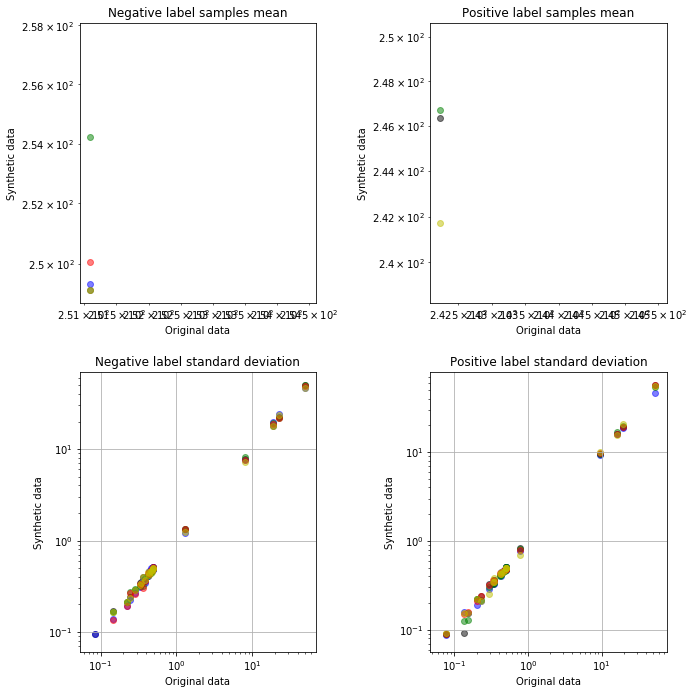

In [10]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,10))

# Negative label mean
ax1 = fig.add_subplot(221)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(x,y, color=colour, alpha=0.5)
ax1.set_xlabel('Original data')#
ax1.set_ylabel('Synthetic data')
ax1.set_title('Negative label samples mean')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()

# Positive label mean
ax2 = fig.add_subplot(222)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(x,y, color=colour, alpha=0.5)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Positive label samples mean')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid()

# Negative label standard deviation
ax3 = fig.add_subplot(223)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    
    colour = colours[run % 7] # Cycle through 7 colours
    ax3.scatter(x,y, color=colour, alpha=0.5)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('Negative label standard deviation')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid()

# Positive label standard deviation
ax4 = fig.add_subplot(224)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax4.scatter(x,y, color=colour, alpha=0.5)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Positive label standard deviation')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('pca.png', facecolor='w', dpi=300)
plt.show()

In [11]:
neg_correlation_synthetic = []
pos_correlation_original = []
pos_correlation_synthetic = []

correl_coeff_neg = []
correl_coeff_pos= []

# Original data
mask = df['label'] == 0
neg_o = df[mask].copy()
neg_o.drop('label', axis=1, inplace=True)
neg_correlation_original = neg_o.corr().values.flatten()

mask = df['label'] == 1
pos_o = df[mask].copy()
pos_o.drop('label', axis=1, inplace=True)
pos_correlation_original = pos_o.corr().values.flatten()

# Synthetic data
for i in range (number_of_runs):
    data_s = synthetic_data[i]
    
    mask = data_s['label'] == 0
    neg_s = data_s[mask].copy()
    neg_s.drop('label', axis=1, inplace=True)
    corr_neg_s = neg_s.corr().values.flatten()
    neg_correlation_synthetic.append(corr_neg_s)
    
    mask = data_s['label'] == 1
    pos_s = data_s[mask].copy()
    pos_s.drop('label', axis=1, inplace=True)
    corr_pos_s = pos_s.corr().values.flatten()
    pos_correlation_synthetic.append(corr_pos_s)

    # Get correlation coefficients
    correl_coeff_neg.append(np.corrcoef(
        neg_correlation_original, corr_neg_s)[0,1])

    correl_coeff_pos.append(np.corrcoef(
        pos_correlation_original, corr_pos_s)[0,1])

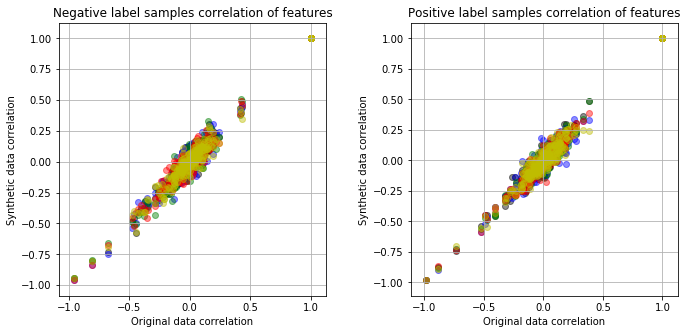

In [12]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(
        neg_correlation_original,
        neg_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax1.grid()
ax1.set_xlabel('Original data correlation')
ax1.set_ylabel('Synthetic data correlation')
ax1.set_title('Negative label samples correlation of features')

ax2 = fig.add_subplot(122)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(
        pos_correlation_original,
        pos_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax2.grid()
ax2.set_xlabel('Original data correlation')
ax2.set_ylabel('Synthetic data correlation')
ax2.set_title('Positive label samples correlation of features')

plt.tight_layout(pad=2)
#plt.savefig('Output/pca_cov.png', facecolor='w', dpi=300)
plt.show()